# Convolutional Neural Network Exercise: <br> Image Classification based on the CIFAR10 Dataset.

__Paul J. Atzberger__

We demonstrate here setup of a convolutional neural networks for image classification using the CIFAR10 dataset [6,7].  The CIFAR10 images have 3 RGB color channels and are 32x32 pixels.  The dataset is represented as a tensor with dimensions Nx3x32x32.  

<img src="./data/convNetSchematic.png" alt="schematic of conv. net" align="center" width="920"/>

To demonstrate concepts, we use a basic convolutional neural network consisting of 2 layers with operations of Convolution -> ReLU -> Max-Pool.  The first layer has a 16 channel convolutional layer with a kernel of size 5 pixels, a ReLU non-linearity, and a max pooling with kernel size of 2 units.  The second layer has a 32 channel convolutional layer with a kernel of size 5 pixels, a ReLU non-linearity, and max pooling with kernel size of 2 units.  This produces $8*8*32 = 2048$ features that we process with a fully-connected layer to use in a softmax assignment of probabilities to the classification categories.  We train the model by minimizing the cross-entropy loss function.

In this exercise, you are to modify the architecture and hyper-parameters to get familar with how convolutional neural networks work and to try to improve their ability to perform this classification task.  You are welcome to experiment with other CNN architectures by stacking additional convolutional layers or by adjusting the width, kernel size, and depth of filters or by performing data augmentation or by making other modifications.  For inspiration, see the papers below for discussions of both historic and modern techniques [1-4].

### References

[1] _Hand written digit recognition with a back-propagation network_, Y. LeCun, In Proc. Advances in Neural Information Processing Systems, (1990).

[2] _Neocognitron: A self-organizing neural network model for a mechanism of pattern recognition unaffected by shift in position_, K. Fukushima, Biological Cybernetics, 36, 4, April (1980). 

[3] _Receptive fields of single neurons in the cat's striate cortex_, Hubel, D.H.; Wiesel, T.N., J Physiol. 148 (3), (1959).  

[4] _Deep learning_, LeCun, Y., Bengio, Y., and Hinton, G., Nature, 521, May, (2015).

[5] _Pytorch-tutorials_, https://pytorch.org/tutorials/, 2017.

[6] _TensorFlow: Large-Scale Machine Learning on Heterogeneous Distributed Systems_, https://arxiv.org/abs/1603.04467, 2015.

[6] CIFAR10 Dataset: Learning Multiple Layers of Features from Tiny Images, Alex Krizhevsky, 2009.

[7] Images CIFAR10 database: https://www.cs.toronto.edu/~kriz/cifar.html


## Setup Codes

In [1]:
import torch;
import torch.nn as nn;
import torchvision;
import torchvision.transforms as transforms;

import numpy as np;
import matplotlib.pyplot as plt;

# Configure devices
if torch.cuda.is_available():
  device = torch.device('cuda:0');
else: 
  device = torch.device('cpu');

# Setup the parameters
learningRate = 0.001;
batchSize = 100;
numCategories = 10;

numEpochs = 5;

#flagDataSet = 'MNIST';
flagDataSet = 'CIFAR10';

print("torch.__version__ = " + str(torch.__version__));
print("numpy.__version__ = " + str(np.__version__));

print("device = " + str(device));


torch.__version__ = 0.4.1.post2
numpy.__version__ = 1.15.1
device = cuda:0


## Function Definitions

In [2]:
def plot_image_array(img_arr,label_arr=None,title=None,figSize=(18,18),title_yp=0.95,cmap="gray"):

    # determine number of images we need to plot
    numSamples = len(img_arr);
    sqrtS      = int(np.sqrt(numSamples));
    rows       = sqrtS;
    cols       = sqrtS;

    #fig, axs = plt.subplots(nrows=rows, ncols=cols, figsize=(18,18));
    fig, axs = plt.subplots(nrows=rows, ncols=cols, figsize=figSize);

    I = 0;
    for i in range(0,sqrtS):
        #print("pid = %d"%pid)
        for j in range(0,sqrtS):
            #img = img_arr[I];
            #print("i,j = (%d,%d)"%(i,j));
            if cmap is not None:
              axs[i,j].imshow(img_arr[I], cmap=cmap);
            else:
              axs[i,j].imshow(img_arr[I]);
            if label_arr is not None:
              axs[i,j].set_title("%s"%label_arr[I]);
            axs[i,j].set_xticks([]);
            axs[i,j].set_yticks([]);
            I += 1;

    if title is None:
      plt.suptitle("Collection of Images", fontsize=18,y=title_yp);
    else:
      plt.suptitle(title, fontsize=18,y=title_yp);
    #plt.subplots_adjust(hspace=0.1,wspace=0.1);

    #plt.subplots_adjust(top=0.92, bottom=0.08, left=0.10, right=0.95, hspace=0.25,
    #                    wspace=0.0)
    

## Load the dataset

In [3]:
if flagDataSet == 'MNIST':
  # MNIST dataset
  train_dataset = torchvision.datasets.MNIST(root='./data/',
                                             train=True, 
                                             transform=transforms.ToTensor(),
                                             download=True);

  test_dataset = torchvision.datasets.MNIST(root='./data/',
                                            train=False, 
                                            transform=transforms.ToTensor());

  categoryNames = ['one','two','three','four','five','six','seven','eight','nine'];
    
elif flagDataSet == 'CIFAR10':
  # CIFAR10 dataset
  train_dataset = torchvision.datasets.CIFAR10(root='./data/',
                                             train=True, 
                                             transform=transforms.ToTensor(),
                                             download=True);

  test_dataset = torchvision.datasets.CIFAR10(root='./data/',
                                            train=False, 
                                            transform=transforms.ToTensor());

  #categoryNames = ['airplane','automobile','bird','cat','deer','dog','frog','horse','ship','truck'];
  categoryNames = ['a-plane','car','bird','cat','deer','dog','frog','horse','ship','truck'];

else:
  print("flagDataSet not recognized.");
  print("flagDataSet = " + str(flagDataSet));
  raise;

# Data loader
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=batchSize, 
                                           shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                          batch_size=batchSize, 
                                          shuffle=False)


Files already downloaded and verified


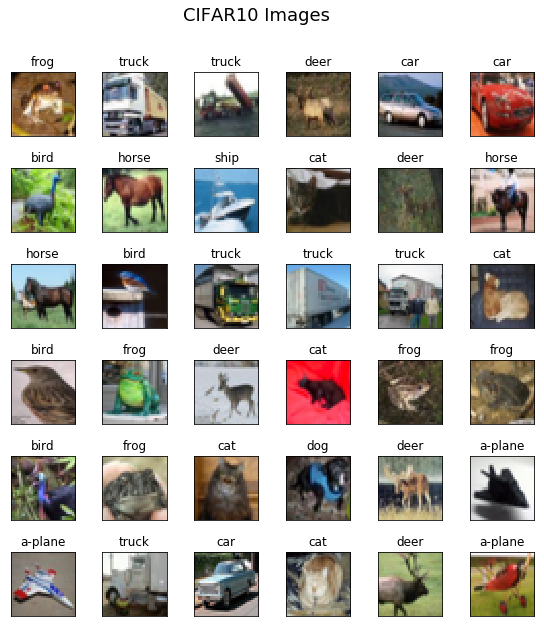

In [4]:
# Show subset of the data 
img_arr = [];
label_str_arr = [];

numImages = len(train_dataset);
#II = np.random.permutation(numImages); # compute random collection of indices @optimize
II = np.arange(numImages);

if flagDataSet == 'MNIST':
  for I in np.arange(0,36):
    img_arr.append(np.array(train_dataset[II[I]][0][0]));
  plot_image_array(img_arr,title='Collection of Digits',figSize=(6,6),title_yp=1.0);
elif flagDataSet == 'CIFAR10':
  for I in np.arange(0,36):
    img = np.array(train_dataset[II[I]][0]);
    img = np.transpose(img,(1,2,0));
    img_arr.append(img);
    l_true_str = categoryNames[train_dataset[II[I]][1]];
    label_str_arr.append(l_true_str);
  plot_image_array(img_arr,label_str_arr,title='CIFAR10 Images',figSize=(9,9),title_yp=1.02,cmap=None);    
  plt.subplots_adjust(top=0.92, bottom=0.08, left=0.10, right=0.95, hspace=0.5, wspace=0.0);

#print(len(img_arr))
#print(img_arr[0].shape)

## Setup the Convolutational Neural Network (CNN)

In [5]:
# Convolutional neural network (two convolutional layers)
class ConvNet(nn.Module):
    def __init__(self, numCategories=10):
        super(ConvNet, self).__init__()
        if flagDataSet == 'MNIST':  # assumed images are given as 1x28x28
          self.layer1 = nn.Sequential(
              nn.Conv2d(in_channels=1, out_channels=16, kernel_size=5, stride=1, padding=2),
              nn.BatchNorm2d(num_features=16),
              nn.ReLU(),
              nn.MaxPool2d(kernel_size=2, stride=2));
          self.layer2 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm2d(num_features=32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2));
          self.fc = nn.Linear(7*7*32, numCategories);
        elif flagDataSet == 'CIFAR10': # assumed images are given as 3x32x32
          self.layer1 = nn.Sequential(
              nn.Conv2d(in_channels=3, out_channels=16, kernel_size=5, stride=1, padding=2),
              nn.BatchNorm2d(num_features=16),
              nn.ReLU(),
              nn.MaxPool2d(kernel_size=2, stride=2));
          self.layer2 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm2d(num_features=32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2));
          self.fc = nn.Linear(8*8*32, numCategories);

    def forward(self, x):
        out = self.layer1(x);
        out = self.layer2(out);
        out = out.reshape(out.size(0), -1);
        out = self.fc(out);
        return out;

model = ConvNet(numCategories).to(device);


## Perform Training of the Neural Network

In [6]:
# setup the optimization method and loss function
optimizer = torch.optim.Adam(model.parameters(), lr=learningRate);
loss_func = nn.CrossEntropyLoss();

print("Training the CNN with:");
print("numEpochs = %d"%numEpochs);
print("batchSize = %d"%batchSize);
print(" ");

# Train the model
numSteps = len(train_loader);
for epoch in range(numEpochs):
    for i, (images, labels) in enumerate(train_loader):
        images = images.to(device);
        labels = labels.to(device);
        
        # Forward pass
        outputs = model(images);
        loss = loss_func(outputs, labels);
        
        # Backward and optimize
        optimizer.zero_grad();
        loss.backward();
        optimizer.step();
        
        if ((i + 1) % 100) == 0:
          print ('Epoch: [%d/%d]; batchStep = [%d/%d]; Loss: %.4f.'%(epoch+1, numEpochs, i + 1, numSteps, loss.item()));


Training the CNN with:
numEpochs = 5
batchSize = 100
 
Epoch: [1/5]; batchStep = [100/500]; Loss: 1.5232.
Epoch: [1/5]; batchStep = [200/500]; Loss: 1.1379.
Epoch: [1/5]; batchStep = [300/500]; Loss: 1.3592.
Epoch: [1/5]; batchStep = [400/500]; Loss: 1.3207.
Epoch: [1/5]; batchStep = [500/500]; Loss: 1.3342.
Epoch: [2/5]; batchStep = [100/500]; Loss: 0.9104.
Epoch: [2/5]; batchStep = [200/500]; Loss: 0.8463.
Epoch: [2/5]; batchStep = [300/500]; Loss: 0.9550.
Epoch: [2/5]; batchStep = [400/500]; Loss: 1.0601.
Epoch: [2/5]; batchStep = [500/500]; Loss: 0.9150.
Epoch: [3/5]; batchStep = [100/500]; Loss: 0.9198.
Epoch: [3/5]; batchStep = [200/500]; Loss: 0.8554.
Epoch: [3/5]; batchStep = [300/500]; Loss: 0.9193.
Epoch: [3/5]; batchStep = [400/500]; Loss: 0.8763.
Epoch: [3/5]; batchStep = [500/500]; Loss: 1.0446.
Epoch: [4/5]; batchStep = [100/500]; Loss: 1.0201.
Epoch: [4/5]; batchStep = [200/500]; Loss: 0.7207.
Epoch: [4/5]; batchStep = [300/500]; Loss: 0.7843.
Epoch: [4/5]; batchStep = [

## Test the Neural Network Predictions 

In [7]:
# Test the model
print("Testing predictions of the neural network:");
print("");

# Save the first few to show as examples of labeling
saved_test_img = [];
saved_test_label_true = [];
saved_test_label_pred = [];

model.eval();  # eval mode (batchnorm uses moving mean/variance instead of mini-batch mean/variance)
with torch.no_grad():
    correct = 0;
    total = 0;
    II = 0;
    for images, labels in test_loader: # loads data in batches and then sums up
        
        if (II >= 1000):
          print("tested on %d images"%total);
          II = 0;
        
        images = images.to(device);
        labels = labels.to(device);
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1);
        total += labels.size(0);
        correct += (predicted == labels).sum().item();
        
        #print(I);
        #print(images.shape);
        #print(labels.shape);
        II += labels.size(0);
        
        img = np.transpose(images[0],(1,2,0)); # sample just first image of the batch
        saved_test_img.append(img);
        saved_test_label_true.append(labels[0].item());
        saved_test_label_pred.append(predicted[0].item());
        
    print("");
    print("Tested on a total of %d images."%total);    
    print("");
    test_accuracy = correct/total;
        
    print("The neural network has an accurary of %.2f%% on the %d test images."%(100*test_accuracy,total));
    #print('Accuracy of the  on the %d test images: {} %'.format(100 * correct / total))

Testing predictions of the neural network:

tested on 1000 images
tested on 2000 images
tested on 3000 images
tested on 4000 images
tested on 5000 images
tested on 6000 images
tested on 7000 images
tested on 8000 images
tested on 9000 images

Tested on a total of 10000 images.

The neural network has an accurary of 63.95% on the 10000 test images.


## Show a Sample of the Predictions 

In [8]:
# collect a subset of the data to show and attach named labels
numSamplesShow = 100;

ss_img   = saved_test_img[0:numSamplesShow];
ss_label_true = saved_test_label_true[0:numSamplesShow];
ss_label_pred = saved_test_label_pred[0:numSamplesShow];

ss_label_str  = [];
numLabels = len(saved_test_label_true);
for i in range(0,numLabels):
  l_true = saved_test_label_true[i];
  l_pred = saved_test_label_pred[i];
  l_pred_str = categoryNames[l_pred];
  l_true_str = categoryNames[l_true];
  #sstr = "%s:%s"%(l_pred,l_true);                
  sstr = "%s:%s"%(l_pred_str,l_true_str);
  ss_label_str.append(sstr);

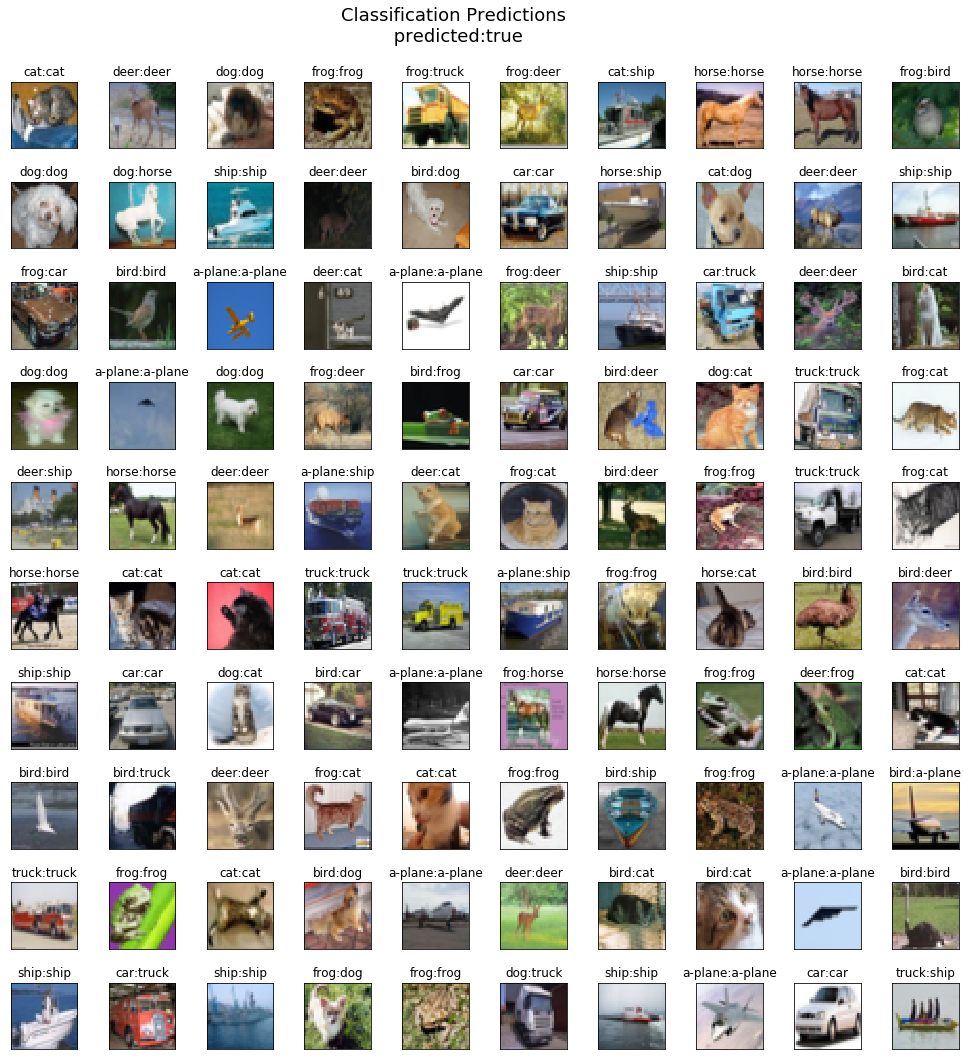

In [9]:
plot_image_array(ss_img,ss_label_str,title="Classification Predictions \n predicted:true",figSize=(16,16),title_yp=0.985);
plt.subplots_adjust(top=0.92, bottom=0.08, left=0.10, right=0.95, hspace=0.5, wspace=0.0);

## Save the Model

In [13]:
# Write the weights to disk for possible later re-use.
# For instance, one could use this trained neural network and 
# try to transfer the learned features for use in other tasks.
torch.save(model.state_dict(), 'cnn_trained.ckpt')

## Summary

We have demonstrated how to formulate and train a basic CNN for image classication using the CIFAR10 image dataset.  This basic CNN used for demonstrating concepts can be improved by further development and adjustments.  Experiment with the CNN architecture and hyperparameters. For instance, by stacking additional convolutional layers or by adjusting the width, kernel size, and depth of filters or by performing data augmentation or by making other modifications.  For inspiration, see the references above for discussions of both historic and modern techniques [1-4]. 